In [130]:
%%writefile infer_single_sentence_LM.py
def infer_language_model(model, tokenizer, sentence:str, max_new_tokens:int, context_size:int):
    encoded_sentence = tokenizer.encode(sentence)
    for i in range(max_new_tokens):        
        sentence_idx_tensor = torch.tensor(encoded_sentence[-context_size:]).unsqueeze(0)
        with torch.no_grad():
            logits = model(sentence_idx_tensor)
        last_token_logits = logits[:, -1, :]
        last_token_probas = torch.softmax(last_token_logits, dim=-1)
        last_token_idx = torch.argmax(last_token_probas, dim=-1) # must keepdim=True to stacking the idx to sentence_idx_tensor
        encoded_sentence.append(last_token_idx)
        yield tokenizer.decode(encoded_sentence)

Writing infer_single_sentence_LM.py


In [ ]:
def infer_language_model(model, sentence:str, max_new_tokens, context_size):
    encoded_sentence = tokenizer.encode(sentence)
    for i in range(max_new_tokens):        
        sentence_idx_tensor = torch.tensor(encoded_sentence[-context_size:]).unsqueeze(0)
        with torch.no_grad():
            logits = model(sentence_idx_tensor)
        last_token_logits = logits[:, -1, :]
        last_token_probas = torch.softmax(last_token_logits, dim=-1)
        last_token_idx = torch.argmax(last_token_probas, dim=-1) # must keepdim=True to stacking the idx to sentence_idx_tensor
        encoded_sentence.append(last_token_idx)
        yield tokenizer.decode(encoded_sentence)

for i in infer_language_model(model, "Omar", 3, 1000):
    print(i,"\r",end="", flush=True)

KeyboardInterrupt: 

# Chapter 5:
### Notes:

In [1]:
from python_scripts.GPT2_model import GPT2Model
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,    #1
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,       #2
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPT2Model(GPT_CONFIG_124M)
model.eval()    

tensor([[[2.0000, 0.0000],
         [1.1199, 0.8801]]], grad_fn=<MulBackward0>)
tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>) torch.Size([2, 6, 2])


GPT2Model(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (repeated_transformer_blocks): Sequential(
    (0): TransformerBasicBlock(
      (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (queries): Linear(in_features=768, out_features=768, bias=False)
        (keys): Linear(in_features=768, out_features=768, bias=False)
        (values): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=3072, out_features=768, bias=True)
      )
      (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (1): Trans

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

def Text2TokenIds(text, tokenizer):
    tensor_ids_unsqueezed = torch.tensor(tokenizer.encode(text, allowed_special={'<|endoftext|>'})).unsqueeze(0)
    return tensor_ids_unsqueezed

def TokenIds2Text(tensor_ids_unsqueezed, tokenizer):
    text = tokenizer.decode(tensor_ids_unsqueezed.squeeze(0).tolist())
    return text

def generate_text_ids_simple(
        model,
        current_ids,
        max_new_tokens=10,
        context_size=GPT_CONFIG_124M['context_length']
):
    for i in range(max_new_tokens):
        if isinstance(current_ids, list):
            current_ids = torch.tensor(current_ids, device="cuda" if torch.cuda.is_available() else "cpu").unsqueeze(0)
        ids_trimmed_tensor = current_ids[:, -context_size:]  # ids_trimmed_tensor --> (batch, num_tokens)
        with torch.no_grad():                          
            logits = model(ids_trimmed_tensor) 
        last_token_logits = torch.softmax(logits[:,-1,:], axis=-1)   # last_token_logits --> (batch, vocab_size)
        last_token_idx_batched = torch.argmax(last_token_logits, dim=-1, keepdim=True) # last_token_idx_batched --> (batch, 1)
        current_ids = torch.cat((current_ids, last_token_idx_batched), dim=1) #current_ids --> (batch, num_tokens + 1)
    return current_ids



IndentationError: expected an indented block after 'if' statement on line 19 (3801127398.py, line 20)

In [3]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

ids = generate_text_ids_simple(model, inputs)
print(TokenIds2Text(ids[0], tokenizer))
print(TokenIds2Text(ids[1], tokenizer))

with torch.no_grad():     #1
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
probas.shape

every effort movesNetflix Pediatrics impossibilityLegendJoined cup Shannon GamergateHay arcade
I really likefaith represents Abe WindsorFE sophisticationLab shave neighbour Been


torch.Size([2, 3, 50257])

In [4]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)

print(f"target_0: {TokenIds2Text(targets[0].flatten(),tokenizer)}")
print(f"Output_0: {TokenIds2Text(token_ids[0].flatten(),tokenizer)}")


target_0:  effort moves you
Output_0:  Armed heNetflix


In [5]:
# the goal is to get the probabilities of the output but not all of them
# we want only those corresponding to the target_tokens ... in order to maxmize them.

idx = 0
Output_probas_corresponding_to_target_tokens_batch_1 = probas[idx, [0,1,2], targets[idx]]
print(Output_probas_corresponding_to_target_tokens_batch_1)

idx = 1
Output_probas_corresponding_to_target_tokens_batch_2 = probas[idx, [0,1,2], targets[idx]]
print(Output_probas_corresponding_to_target_tokens_batch_2)


tensor([7.4536e-05, 3.1061e-05, 1.1563e-05])
tensor([1.0337e-05, 5.6771e-05, 4.7559e-06])


In [6]:
log_probas = torch.log(torch.cat((Output_probas_corresponding_to_target_tokens_batch_1, 
                                  Output_probas_corresponding_to_target_tokens_batch_2),dim=0)
                                  )
print(log_probas)
neg_avg_log_probas = torch.mean(log_probas) * -1  # this conversion is known as cross_entropy
print(neg_avg_log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7765, -12.2561])
tensor(10.7940)


In [7]:
print("Logits shape: ", logits.shape)
print("targets shape: ", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
targets shape:  torch.Size([2, 3])


In [8]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])

with torch.no_grad():     
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)   # logits --> (batch, num_tokens, vocab_size)
                                         # targets --> (batch, num_tokens)
idx = 0
Output_probas_corresponding_to_target_tokens_batch_1 = probas[idx, [0,1,2], targets[idx]]

idx = 1
Output_probas_corresponding_to_target_tokens_batch_2 = probas[idx, [0,1,2], targets[idx]]

log_probas = torch.log(torch.cat((Output_probas_corresponding_to_target_tokens_batch_1, 
                                  Output_probas_corresponding_to_target_tokens_batch_2),dim=0)
                                  )
neg_avg_log_probas = torch.mean(log_probas) * -1  # this conversion is known as cross_entropy
print("neg_avg_log_probas: ", neg_avg_log_probas)

# --------------------------------------------------
# the above is encapsulated in torch.cross

logits_flattened = logits.flatten(0,1)  # logits_flattened (batch*num_tokens, vocab_size)
targets_flattened = targets.flatten()    # targets_flattened (batch*num_tokens)
loss = torch.nn.functional.cross_entropy(logits_flattened, targets_flattened)
print("corss_entropy_loss: ", loss)
print("perplexity is: ", torch.exp(loss))

neg_avg_log_probas:  tensor(10.7940)
corss_entropy_loss:  tensor(10.7940)
perplexity is:  tensor(48726.5195)


In [9]:
file_path = "the-verdict.txt"

with open(file_path,'r', encoding='utf-8') as file:
    text_data = file.read()

total_characters = len(text_data)
total_characters


20479

In [10]:
total_tokens = len(tokenizer.encode(text_data))
total_tokens
split_idx = int(total_characters * 0.9)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [ ]:
from python_scripts import data_processor

train_ds = data_processor.GPT2Dataset(text=train_data,max_length=GPT_CONFIG_124M['context_length'],
                                         stride=GPT_CONFIG_124M['context_length'])
train_dl = data_processor.GPT2DataLoader(train_ds, batch_size=2,
                                         drop_last=True,
                                         shuffle=True,
                                         num_workers=0)

val_ds = data_processor.GPT2Dataset(text=val_data,max_length=GPT_CONFIG_124M['context_length'],
                                         stride=GPT_CONFIG_124M['context_length'])
val_dl = data_processor.GPT2DataLoader(val_ds, batch_size=2,
                                         drop_last=False,
                                         shuffle=False,
                                         num_workers=0)


Starting batch 0 >>>>> 
Engind batch 0 <<<< 
Starting batch 1 >>>>> 
Engind batch 1 <<<< 
Starting batch 2 >>>>> 
Engind batch 2 <<<< 
Starting batch 3 >>>>> 
Engind batch 3 <<<< 
Starting batch 4 >>>>> 
Engind batch 4 <<<< 
Starting batch 5 >>>>> 
Engind batch 5 <<<< 
Starting batch 6 >>>>> 
Engind batch 6 <<<< 
Starting batch 7 >>>>> 
Engind batch 7 <<<< 
Starting batch 8 >>>>> 
Engind batch 8 <<<< 
Starting batch 9 >>>>> 
Engind batch 9 <<<< 


In [12]:
for x,y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([2, 256]) torch.Size([2, 256])


In [13]:
def calc_loss_for_single_batch(input_batch, target_batch, model, device): # input_batch --> (batch_size, num_tokens) ,,,, taret_batch --> (batch_size, num_tokens)
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    model = model.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss
for x,y in train_dl:
    loss = calc_loss_for_single_batch(x,y, model, device="cuda" if torch.cuda.is_available() else "cpu")
    print(loss)

tensor(10.9682, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9779, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(11.0111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9543, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(11.0158, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9986, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9912, device='cuda:0', grad_fn=<NllLossBackward0>)


In [14]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)

    for i, (x,y) in enumerate(data_loader):
        if i < num_batches:
            total_loss += calc_loss_for_single_batch(x, y, model, device).item()
        else:
            break
    return total_loss / num_batches
    
    

In [15]:
val_loss = calc_loss_loader(val_dl, model, "cuda" if torch.cuda.is_available() else "cpu")
val_loss

10.981103897094727

In [ ]:
def generate_sample(model, tokenizer, device, start_context):
    ids = tokenizer.encode(start_context)
    context_size = model.pos_emb.weight.shape[0]
    with torch.no_grad():
        ids = generate_text_ids_simple(model, ids, max_new_tokens=50,
                                context_size=context_size)
    decoded_text = TokenIds2Text(ids, tokenizer)
    print(decoded_text.replace("\n"," "))


def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, start_context, tokenizer):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, 0
    for epoch in range(num_epochs): 
        for x,y in train_loader:
            model.train()
            optimizer.zero_grad()
            loss = calc_loss_for_single_batch(x,y,model, device)
            loss.backward()
            optimizer.step()
            tokens_seen = x.numel()
            global_step +=1

            if global_step % eval_freq == 0:
                model.eval()
                train_loss = calc_loss_loader(train_loader, model, device)
                val_loss = calc_loss_loader(val_loader, model, device)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (step {global_step:06d}):"
                    f"Train Loss: {train_loss:.3f}, "
                    f"Val Loss {val_loss:.3f}"
                )

                
        generate_sample(start_context, model, tokenizer)


: 

In [ ]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
device = "cpu"
tokenizer =tiktoken.get_encoding('gpt2')
torch.cuda.empty_cache()
train_model_simple(model, train_dl, val_dl, optimizer, device, num_epochs,
                   eval_freq=5, start_context="Omar is a good ", tokenizer=tokenizer)

In [34]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 4         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1787 MiB |   3804 MiB |  23693 MiB |  21905 MiB |
|       from large pool |   1766 MiB |   3777 MiB |  22678 MiB |  20912 MiB |
|       from small pool |     20 MiB |     26 MiB |   1014 MiB |    993 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   1787 MiB |   3804 MiB |  23693 MiB |  21905 MiB |
|       from large pool |   1766 MiB |   3777 MiB |  22678 MiB |

In [40]:
import torch

vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [ ]:
# 1. Controlling inference using Multinomial Distribution:

probas = torch.softmax(next_token_logits, dim=0)
sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]

indices = torch.bincount(torch.tensor(sample))
for i, count in enumerate(indices):
    print(f"{inverse_vocab[i]} x {count}")

closer x 69
every x 2
effort x 0
forward x 576
inches x 4
moves x 1
pizza x 0
toward x 345
you x 3


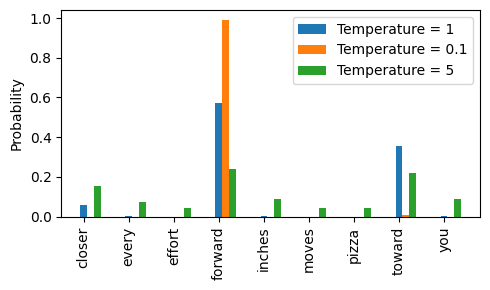

In [58]:
# 2. Controlling inference using Temperature Scaling:

def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-1)

import matplotlib.pyplot as plt
temperatures = [1, 0.1, 5]                                     #1
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], 
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 3. Controlling Inference using Top_K sampling:

top_k = 3
top_logits, indices = torch.topk(next_token_logits, top_k if top_k <= len(next_token_logits) else len(next_token_logits)) 
logits =  torch.where(
        condition = next_token_logits < top_logits[-1],
        input = torch.tensor(float('-inf')),
        other = next_token_logits 
    ) 

probas = torch.softmax(logits, dim=0)
probas



9

In [ ]:
# modify the generate method:

def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-1)


def generate(model, idx, max_new_token, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    
    for i in range(max_new_token):
        if isinstance(idx, list):
            idx = torch.tensor(idx, device="cuda" if torch.cuda.is_available() else "cpu").unsqueeze(0)

        if idx.dim() == 2: 
            idx = idx[:, -context_size: ]
        elif idx.dim() == 1:
            idx = idx[-context_size: ].unsqueeze(0)
        
        with torch.no_grad():
            logits = model(idx)
        last_token_logit = logits[:, -1, :]   # last_token_logits --> (batch_size, vocab_size)
        
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k if top_k < logits.shape[-1] else logits.shape[-1])
            last_token_logits = torch.where(
                condition= last_token_logit < top_logits[:,-1],
                input= torch.tensor(float("-inf")),
                other= last_token_logit
            )
            
        if temperature > 0.0:
            last_token_probas = softmax_with_temperature(last_token_logit, temperature)
            last_token_idx = torch.multinomial(last_token_probas, num_samples=1)
        else:
            last_token_idx = torch.argmax(last_token_logit, dim=-1, keepdim=True)

        idx = torch.cat((idx, last_token_idx), dim=1)

    return idx

